Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [37]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling, BatchNormalization

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
root_data_path = "/content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment"
data_dir_train = pathlib.Path(root_data_path + "/Train")
data_dir_test = pathlib.Path(root_data_path + '/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    directory=data_dir_train,
    labels="inferred",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
  )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    directory=data_dir_train,
    labels="inferred",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
  )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

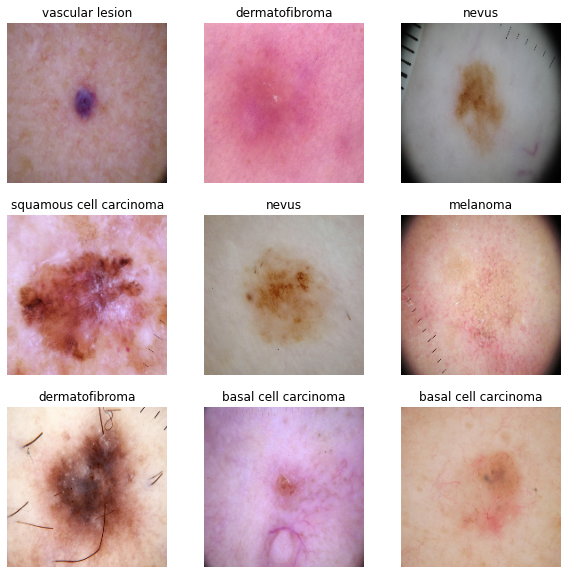

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [55]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [56]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [80]:
### Your code goes here
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [81]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [82]:
# View the summary of all layers
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_42 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 conv2d_35 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_43 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                      

### Train the model

In [83]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 89ms/step - loss: 2.3060 - accuracy: 0.2612 - val_loss: 1.6754 - val_accuracy: 0.4295
Epoch 2/20
56/56 [==============================] - 5s 86ms/step - loss: 1.7865 - accuracy: 0.3583 - val_loss: 1.6844 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 5s 86ms/step - loss: 1.7019 - accuracy: 0.3823 - val_loss: 1.6344 - val_accuracy: 0.4362
Epoch 4/20
56/56 [==============================] - 5s 86ms/step - loss: 1.6261 - accuracy: 0.4191 - val_loss: 1.5791 - val_accuracy: 0.4385
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 1.5962 - accuracy: 0.4280 - val_loss: 1.4950 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 5s 88ms/step - loss: 1.4553 - accuracy: 0.4760 - val_loss: 1.6644 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 5s 88ms/step - loss: 1.3923 - accuracy: 0.5112 - val_loss: 1.4978 - val_accuracy: 0.4989
Epoch 8/20
56

### Visualizing training results

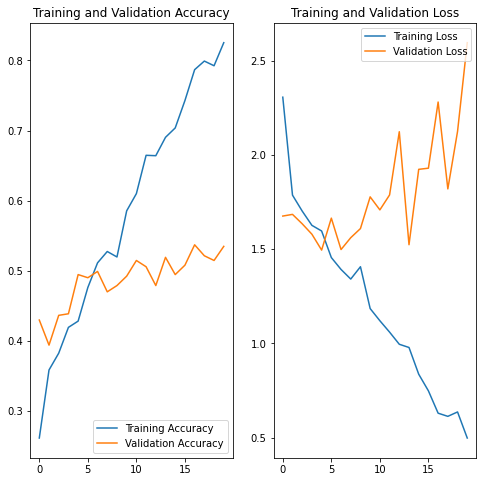

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [101]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
  ]
)

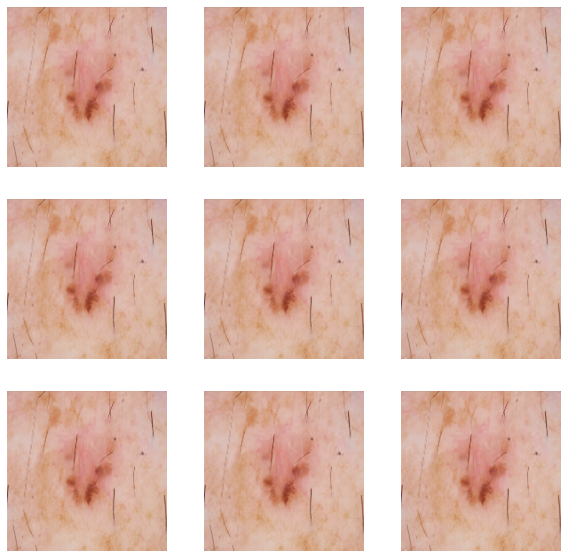

In [105]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [106]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compiling the model

In [107]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [108]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 106ms/step - loss: 3.0978 - accuracy: 0.1903 - val_loss: 2.0245 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 104ms/step - loss: 2.0572 - accuracy: 0.1791 - val_loss: 2.0314 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 104ms/step - loss: 2.0266 - accuracy: 0.2003 - val_loss: 1.9837 - val_accuracy: 0.2506
Epoch 4/20
56/56 [==============================] - 6s 113ms/step - loss: 1.9016 - accuracy: 0.2896 - val_loss: 1.7194 - val_accuracy: 0.3490
Epoch 5/20
56/56 [==============================] - 6s 104ms/step - loss: 1.7489 - accuracy: 0.3599 - val_loss: 1.6149 - val_accuracy: 0.4251
Epoch 6/20
56/56 [==============================] - 6s 105ms/step - loss: 1.6482 - accuracy: 0.4102 - val_loss: 1.7017 - val_accuracy: 0.3691
Epoch 7/20
56/56 [==============================] - 6s 104ms/step - loss: 1.6228 - accuracy: 0.4291 - val_loss: 1.5836 - val_accuracy: 0.4251
Epoch 

### Visualizing the results

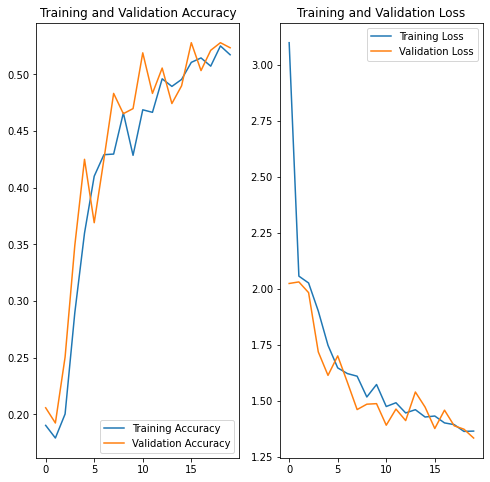

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [20]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)
count = labels.value_counts()
print(count)

5    370
3    352
1    309
4    277
7    142
8    115
0     92
2     77
6     58
dtype: int64


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [21]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [23]:
# path_to_training_dataset=data_dir_train.
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train.joinpath(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F607C970CD0>: 100%|██████████| 500/500 [00:18<00:00, 27.50 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6165CCF0D0>: 100%|██████████| 500/500 [00:18<00:00, 26.42 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F609208B2D0>: 100%|██████████| 500/500 [00:20<00:00, 24.69 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F607C829090>: 100%|██████████| 500/500 [01:37<00:00,  5.15 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2583x2096 at 0x7F607C80C210>: 100%|██████████| 500/500 [01:29<00:00,  5.59 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F607C7FF150>: 100%|██████████| 500/500 [00:18<00:00, 27.19 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F607C7A7B10>: 100%|██████████| 500/500 [00:40<00:00, 12.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F607C974390>: 100%|██████████| 500/500 [00:19<00:00, 25.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F607C824210>: 100%|██████████| 500/500 [00:18<00:00, 27.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [24]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_b255a2e4-eb4a-403f-91b1-493f19e3c8b9.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030665.jpg_f7474a6f-eff8-4b3d-b88e-6d7544bd40c0.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_78648183-a145-4618-8cb3-b77fc5eee0ab.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025314.jpg_dec64ad1-8e0f-4e43-9a36-bd94ec04bff2.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025911.jpg_bbe7c3bb-6526-40c7-9be7-afc42b3c3ec0.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Dataset/CNN_assignment/Train/dermatofibroma/output/dermatofibroma_origina

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

NameError: ignored

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 49s 226ms/step - loss: 13.6797 - accuracy: 0.2187 - val_loss: 83.2730 - val_accuracy: 0.1143
Epoch 2/30
169/169 [==============================] - 36s 207ms/step - loss: 2.1375 - accuracy: 0.1936 - val_loss: 70.1326 - val_accuracy: 0.1678
Epoch 3/30
169/169 [==============================] - 35s 203ms/step - loss: 2.0428 - accuracy: 0.2185 - val_loss: 6.7421 - val_accuracy: 0.2635
Epoch 4/30
169/169 [==============================] - 36s 207ms/step - loss: 1.9920 - accuracy: 0.2493 - val_loss: 2.4889 - val_accuracy: 0.3534
Epoch 5/30
169/169 [==============================] - 37s 210ms/step - loss: 1.9381 - accuracy: 0.2706 - val_loss: 2.3991 - val_accuracy: 0.2324
Epoch 6/30
169/169 [==============================] - 37s 215ms/step - loss: 2.0065 - accuracy: 0.2342 - val_loss: 2.0483 - val_accuracy: 0.3474
Epoch 7/30
169/169 [==============================] - 35s 203ms/step - loss: 1.9355 - accuracy: 0.2626 - val_loss: 6.9893 - val

#### **Todo:**  Visualize the model results

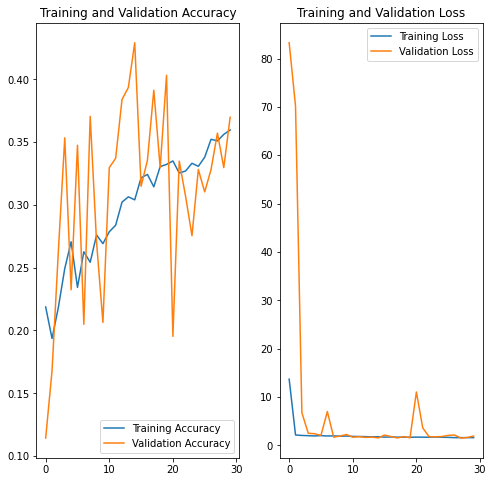

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

